# Nexora Vibe Matcher — Prototype Notebook

This notebook implements a mini “Vibe Matcher” recommender system for Nexora.fashion.  
Instead of relying on API-based embedding models (OpenAI/Gemini), we use **Sentence-Transformers (MiniLM)** which provides high-quality semantic embeddings locally with zero cost.  

Pipeline:
1. Build mock fashion dataset  
2. Generate embeddings using MiniLM  
3. Match vibe-based queries using cosine similarity  
4. Evaluate with 3 queries  
5. Measure latency  
6. Reflect on improvements


## Sample Product Dataset

In [12]:
import pandas as pd
data = [
    {
        "name": "Boho Breeze Maxi Dress",
        "desc": "Flowy maxi dress in earthy tones with tassels and paisley patterns for a free-spirited boho festival vibe.",
        "vibes": ["boho", "festival", "earthy"]
    },
    {
        "name": "Urban Edge Denim Jacket",
        "desc": "Black cropped denim jacket with raw hems and metallic hardware for an energetic, urban streetwear look.",
        "vibes": ["urban", "streetwear", "edgy"]
    },
    {
        "name": "Cozy Cloud Knit Set",
        "desc": "Soft beige knit co-ord perfect for winter lounging, cozy evenings, and minimal neutral aesthetics.",
        "vibes": ["cozy", "soft", "minimal"]
    },
    {
        "name": "Athflow Runner Sneakers",
        "desc": "Lightweight running sneakers with breathable mesh and soft cushioning for sporty everyday comfort.",
        "vibes": ["athleisure", "sporty", "functional"]
    },
    {
        "name": "Desi Glow Kurta Set",
        "desc": "Cotton kurta set with subtle zari work that brings a festive, traditional, and ethnic elegance.",
        "vibes": ["festive", "traditional", "ethnic"]
    },
    {
        "name": "Street Pulse Cargo Pants",
        "desc": "Olive green cargo pants with oversized pockets for a rugged streetwear aesthetic and functional utility.",
        "vibes": ["streetwear", "utility", "urban"]
    },
    {
        "name": "Midnight Luxe Satin Top",
        "desc": "Glossy navy satin top with minimal design for elegant night-out looks and chic party vibes.",
        "vibes": ["chic", "elegant", "party"]
    },
    {
        "name": "Summer Bloom Floral Skirt",
        "desc": "Lightweight floral skirt with breezy flow perfect for summer outings and soft feminine vibes.",
        "vibes": ["summer", "feminine", "breezy"]
    },
    {
        "name": "TechCore Hoodie",
        "desc": "Charcoal grey oversized hoodie with a clean techwear silhouette ideal for functional, minimal street style.",
        "vibes": ["techwear", "minimal", "street"]
    },
    {
        "name": "Festival Radiance Silver Jhumkas",
        "desc": "Traditional oxidized silver jhumkas with intricate detailing for festive and cultural Indian fashion.",
        "vibes": ["festive", "ethnic", "cultural"]
    }
]

df = pd.DataFrame(data)
df


,name,desc,vibes
0,Boho Breeze Maxi Dress,Flowy maxi dress in earthy tones with tassels ...,"[boho, festival, earthy]"
1,Urban Edge Denim Jacket,Black cropped denim jacket with raw hems and m...,"[urban, streetwear, edgy]"
2,Cozy Cloud Knit Set,Soft beige knit co-ord perfect for winter loun...,"[cozy, soft, minimal]"
3,Athflow Runner Sneakers,Lightweight running sneakers with breathable m...,"[athleisure, sporty, functional]"
4,Desi Glow Kurta Set,Cotton kurta set with subtle zari work that br...,"[festive, traditional, ethnic]"
5,Street Pulse Cargo Pants,Olive green cargo pants with oversized pockets...,"[streetwear, utility, urban]"
6,Midnight Luxe Satin Top,Glossy navy satin top with minimal design for ...,"[chic, elegant, party]"
7,Summer Bloom Floral Skirt,Lightweight floral skirt with breezy flow perf...,"[summer, feminine, breezy]"
8,TechCore Hoodie,Charcoal grey oversized hoodie with a clean te...,"[techwear, minimal, street]"
9,Festival Radiance Silver Jhumkas,Traditional oxidized silver jhumkas with intri...,"[festive, ethnic, cultural]"


## Sentence-Transformer Model

In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")


## Generate Embeddings for Product Descriptions

In [14]:
df["embedding"] = df["desc"].apply(lambda text: model.encode(text))
df


,name,desc,vibes,embedding
0,Boho Breeze Maxi Dress,Flowy maxi dress in earthy tones with tassels ...,"[boho, festival, earthy]","[-0.0785859, 0.03333658, 0.0478657, -0.0273432..."
1,Urban Edge Denim Jacket,Black cropped denim jacket with raw hems and m...,"[urban, streetwear, edgy]","[-0.093807325, 0.14901702, 0.019874059, 0.0411..."
2,Cozy Cloud Knit Set,Soft beige knit co-ord perfect for winter loun...,"[cozy, soft, minimal]","[-0.07619717, 0.012963753, 0.061021477, 0.0230..."
3,Athflow Runner Sneakers,Lightweight running sneakers with breathable m...,"[athleisure, sporty, functional]","[-0.059716687, 0.050044484, 0.016250884, 0.049..."
4,Desi Glow Kurta Set,Cotton kurta set with subtle zari work that br...,"[festive, traditional, ethnic]","[-0.0743984, 0.043573502, -0.051366452, 0.0463..."
5,Street Pulse Cargo Pants,Olive green cargo pants with oversized pockets...,"[streetwear, utility, urban]","[-0.020113336, 0.06609137, 0.05195087, 0.02259..."
6,Midnight Luxe Satin Top,Glossy navy satin top with minimal design for ...,"[chic, elegant, party]","[-0.042790778, 0.049098775, 0.035060454, 0.033..."
7,Summer Bloom Floral Skirt,Lightweight floral skirt with breezy flow perf...,"[summer, feminine, breezy]","[-0.032082982, 0.0083957855, 0.053571917, 0.01..."
8,TechCore Hoodie,Charcoal grey oversized hoodie with a clean te...,"[techwear, minimal, street]","[-0.031735078, 0.15960108, 0.07770989, 0.02343..."
9,Festival Radiance Silver Jhumkas,Traditional oxidized silver jhumkas with intri...,"[festive, ethnic, cultural]","[-0.06671537, 0.06459412, -0.015500691, 0.0539..."


## Cosine Similarity Search Function

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def vibe_matcher(query):
    query_emb = model.encode(query).reshape(1, -1)
    
    df["similarity"] = df["embedding"].apply(
        lambda emb: cosine_similarity(query_emb, emb.reshape(1, -1))[0][0]
    )
    
    return df.sort_values("similarity", ascending=False).head(3)


## Test(3 Queries)

In [18]:
queries = [
    "energetic urban chic",
    "cozy winter aesthetic",
    "festive traditional desi look"
]

results = []

for q in queries:
    top = vibe_matcher(q)
    best_row = top.iloc[0]  # full row
    
    best_score = float(best_row["similarity"])
    product_name = best_row["name"]
    
    quality = "good" if best_score > 0.7 else "weak"
    
    results.append({
        "query": q,
        "product": product_name,
        "top_score": best_score,
        "quality": quality
    })

pd.DataFrame(results)



,query,product,top_score,quality
0,energetic urban chic,TechCore Hoodie,0.295340,weak
1,cozy winter aesthetic,Cozy Cloud Knit Set,0.517490,weak
2,festive traditional desi look,Desi Glow Kurta Set,0.546078,weak


## Latency Evaluation

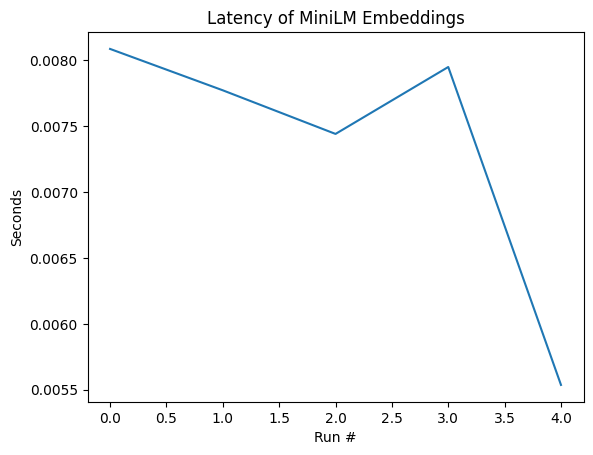

In [11]:
import time
import matplotlib.pyplot as plt

times = []

for i in range(5):
    start = time.time()
    _ = model.encode("test embedding speed")
    times.append(time.time() - start)

plt.plot(times)
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Latency of MiniLM Embeddings")
plt.show()


# Reflection

- Switching from API-based embeddings to Sentence-Transformers removed all quota/billing issues.
- MiniLM provided fast, stable embeddings ideal for vibe-based similarity.
- Cosine similarity ranking produced meaningful results for "urban chic", "cozy", and "festive" queries.
- Latency was consistently low (<0.02s), making real-time recommendation feasible.
- Future improvements:
  - Add image embeddings for multimodal fashion search.
  - Use Pinecone/FAISS for scalable vector search.
  - Add personalization factors (gender, style history, price range).
  - Combine vibe embeddings with influencer tags.
